**IMPORTING LIBRARIES AND LOADING DATASET**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sklearn.tree as tree
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
from subprocess import call
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading file
titanic=pd.read_csv('titanic-passengers.csv', sep=';')

In [3]:
#Inspecting data
print(titanic.describe())
print(titanic.info())

       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    3.000000   80.000000    8.000000    6.000000  512.329200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass     

**DATA CLEANING**

In [4]:
#Filling nans in age column with mean age of people from the same sex and Pclass
grouped=titanic.groupby(['Sex', 'Pclass'])
def cleaning(group):
    return group.fillna(group.mean())
titanic['Age']=grouped['Age'].transform(cleaning)

In [5]:
#Filling nans values in embarked column with the most frequent value
print(titanic['Embarked'].value_counts())
titanic['Embarked']=titanic['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [6]:
#Dropping unnecessary columns - PassengerID, ticket and cabin
titanic.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

**FEATURE ENGINEERING**

In [7]:
#Adding column with information about family size
titanic['FamilySize']= titanic['SibSp']+titanic['Parch']+1

In [8]:
#Adding column IsAlone: 0 - travelling with family, 1 - travelling alone
titanic['IsAlone']=1
titanic['IsAlone'].loc[titanic['FamilySize']>1]=0

In [9]:
#Extracting titles from name column and creating column Title
titanic['Title']=titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs'}, inplace=True)
titanic['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Countess', 'Lady', 'Don', 'Capt', 'Sir'], 'Special', inplace=True)

In [10]:
#Creating column with age group
titanic['GroupAge']=pd.cut(titanic['Age'], 4, labels=False)

In [11]:
#Creating column with fare group
titanic['GroupFare']=pd.qcut(titanic['Fare'],4, labels=False)

In [12]:
#Dropping unnecessary columns
titanic.drop(['FamilySize', 'Name', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

In [13]:
#Creating dummy variables for categorical columns
titanic=pd.get_dummies(titanic, columns=['Pclass', 'Sex', 'Embarked', 'Title'], drop_first=True)

In [14]:
#Inspecting data
print(titanic.head())
print(titanic.describe())
print(titanic.info())

  Survived  IsAlone  GroupAge  GroupFare  Pclass_2  Pclass_3  Sex_male  \
0       No        1         1          1         1         0         1   
1       No        1         1          0         0         1         1   
2       No        1         0          0         0         1         1   
3       No        0         1          2         0         1         0   
4       No        0         1          3         0         0         1   

   Embarked_Q  Embarked_S  Title_Miss  Title_Mr  Title_Mrs  Title_Special  
0           0           1           0         1          0              0  
1           0           1           0         1          0              0  
2           0           1           0         1          0              0  
3           0           1           0         0          1              0  
4           0           1           0         1          0              0  
          IsAlone    GroupAge   GroupFare    Pclass_2    Pclass_3    Sex_male  \
count  891.000000 

**SPLITTING DATASET INTO TRAIN AND TEST**

In [15]:
#Extract feature columns and target column
X=titanic.drop('Survived', axis=1)
y=titanic['Survived']

In [16]:
#split dataset to train and test sample
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

**BUILDING AND EVALUATING DECISION TREES**

In [17]:
#function which makes prediction on given model and return auc score
def prediction_auc(X, y_true):
    y_pred=decisiontree.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
    result = auc(false_positive_rate, true_positive_rate)
    return result

#plotting results for train and test data depending on teste variable
def plotting(x, x_name, list_auc_train, list_auc_test):
    plt.plot(x, list_auc_train, label='train')    
    plt.plot(x, list_auc_test, label='test')
    plt.legend()
    plt.xlabel(x_name)
    plt.ylabel('AUC score')
    plt.show()

#function which return image of tree's structure
def visualizing_tree(tree, name):
    export_graphviz(tree, out_file='tree.dot',feature_names = X_train.columns.tolist(), class_names=['Not Survived', 'Survived'], rounded = True, proportion = False, precision = 2, filled = True)
    call(['dot', '-Tpng', 'tree.dot', '-o', name, '-Gdpi=600'])
    return Image(filename = name)

* TUNING MAX DEPTH

In [18]:
max_depths=range(1,31) #creating list of values to check

list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of max depth
for max_depth in max_depths:
    decisiontree=DecisionTreeClassifier(max_depth=max_depth)
    decisiontree.fit(X_train,y_train)
    
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(max_depths, 'max depth', list_auc_train, list_auc_test)

ValueError: y_true takes value in {'No', 'Yes'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [19]:
#buliding tree with max depth=4
decisiontree_depth_4=DecisionTreeClassifier(max_depth=4)
decisiontree_depth_4.fit(X_train,y_train)
y_pred=decisiontree_depth_4.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)

ValueError: y_true takes value in {'No', 'Yes'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [20]:
#visualizing tree structure
visualizing_tree(decisiontree_depth_4, 'tree_depth_4.png')

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable

* TUNING MIN SAMPLES SPLIT

In [21]:
min_samples_splits=np.linspace(0.05,0.4,8) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples split
for min_samples_split in min_samples_splits:
    decisiontree=DecisionTreeClassifier(min_samples_split=min_samples_split)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_splits, 'min samples split', list_auc_train, list_auc_test)

ValueError: y_true takes value in {'No', 'Yes'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [22]:
#building tree with min samples split=0.1 and visualizing its structure
decisiontree_split_01=DecisionTreeClassifier(min_samples_split=0.1)
decisiontree_split_01.fit(X_train,y_train)
y_pred=decisiontree_split_01.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
visualizing_tree(decisiontree_split_01, 'tree_split_01.png')

ValueError: y_true takes value in {'No', 'Yes'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

* TUNING MIN SAMPLES LEAF

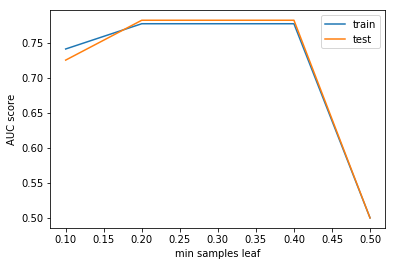

In [23]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples leaf
for min_samples_leaf in min_samples_leafs:
    decisiontree=DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_leafs, 'min samples leaf', list_auc_train, list_auc_test)

AUC score:  0.7823680823680824


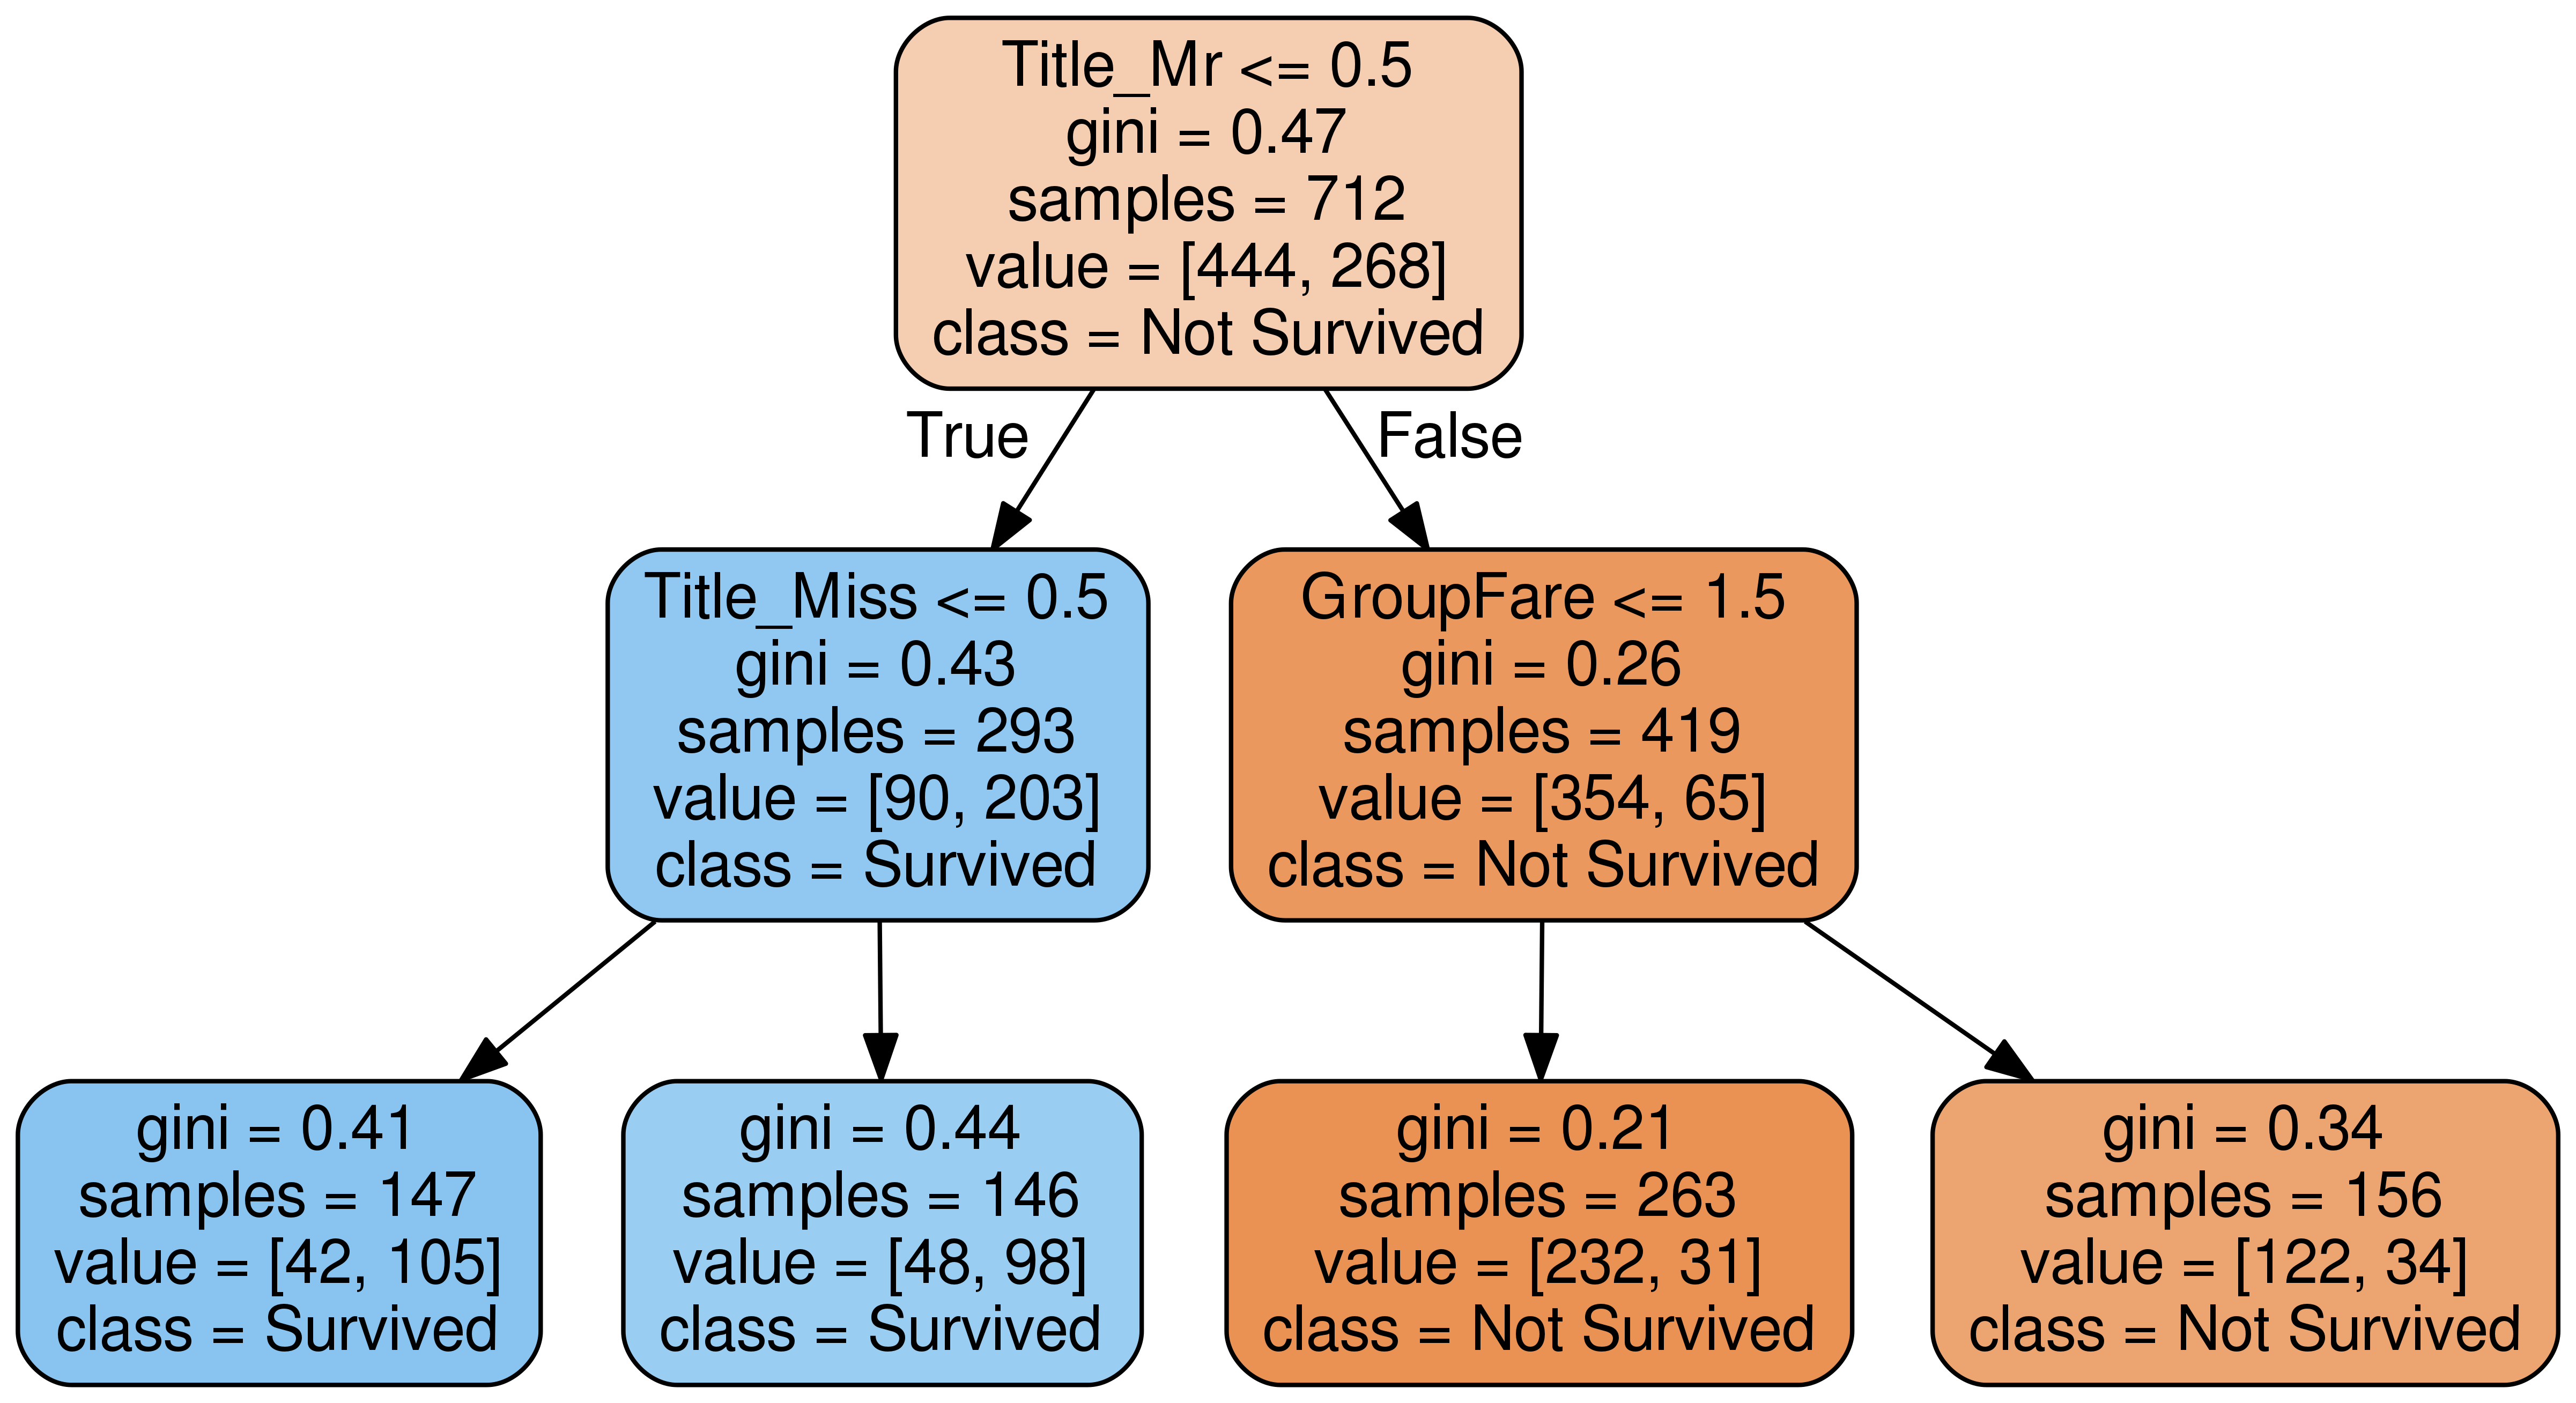

In [24]:
#building tree with min samples leaf=0.2 and visualizing its structure
decisiontree_leaf_02=DecisionTreeClassifier(min_samples_leaf=0.2)
decisiontree_leaf_02.fit(X_train,y_train)
y_pred=decisiontree_leaf_02.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
visualizing_tree(decisiontree_leaf_02, 'tree_leaf_02.png')

**BUILDING AND EVALUATING RANDOM FOREST**

In [25]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 18}


In [26]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 19}
